### Import packages

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import time
pd.set_option('max_colwidth',400)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.utils.data
import random
import warnings
warnings.filterwarnings("ignore", message="F-score is ill-defined and being set to 0.0 due to no predicted samples.")
import re
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from tqdm import tqdm
tqdm.pandas()

### Read in data and take a look

In [36]:
train = pd.read_csv("quora-insincere-questions-classification/train.csv")
test = pd.read_csv("quora-insincere-questions-classification/test.csv")
sub = pd.read_csv('quora-insincere-questions-classification/sample_submission.csv')

In [37]:
import os
print('Available embeddings:', os.listdir("quora-insincere-questions-classification/embeddings/"))

Available embeddings: ['glove.840B.300d']


In [38]:
train["target"].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [39]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [40]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [41]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [42]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 71.


### Preprocess

In [ ]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [44]:
def clean_text(x):
    x = str(x)
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^{|}~' + '“”’':
        x = x.replace(punct, f' {punct} ')
    for punct in '_`':
        x = x.replace(punct, ' ')
    return x

In [45]:
train["question_text"] = train["question_text"].progress_apply(lambda x: clean_text(x))

100%|██████████| 1306122/1306122 [00:09<00:00, 143022.41it/s]


In [46]:
import re
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispell_dict={'quora':'quetion and answer website'}
# mispell_dict = {'quora' : 'question and answer website',
#                 'Quoran':'user' , 'Quorans' : 'user' ,
#                 'BITSAT':'exam' , 
#                 'COMEDK':'exam' , 
#                 'NMAT':'exam',
#                 'KVPY':'exam' , 
#                 'WBJEE':'exam' , 
#                 'VITEEE':'exam' , 
#                 'UCEED':'exam' , 
#                 'UPSEE':'exam', 
#                 'AMCAT':'exam',
#                 'IITJEE':'exam',
#                 'mtech' : 'master of engineering',
#                 'articleship' : 'internship',
#                 'UPES' : 'University of Petroleum and Energy Studies',
#                 'aadhar' : 'identification number',
#                 'adhar':'identification number',
#                 'marksheet' : 'record tool',
#                 'Fortnite' : 'online game',
#                 'AFCAT' : 'Air Force Common Admission Test',
#                 'bcom' : 'Bachelor of Commerce',
#                 'dropshipping' : 'drop shipping',
#                 'BNBR' : 'be nice be respectful',
#                 'IITian' : 'alumni',
#                 'ICOs' : 'inital coin offerings',
#                 'L&T':'company',
#                 'JIIT':'university',
#                 'LNMIIT':'university',
#                 'Zerodha':'company',
#                 'Kavalireddi':'person',
#                 'Binance':'company',
#                 'R&D':'research and develop',
#                 'etc…':'etc',
#                 'Doklam':'area',
#                 'AT&T':'company',
#                 'NICMAR':'National Institute of Construction Management and Research',
#                 'Vajiram':'institue',
#                 'fiitjee':'exam',
#                 'Unacademy':'company',
#                 'D&D':'game',
#                 'MUOET':'test',
#                 'WooCommerce':'plugin',
#                 'INFJs':'acronym',
#                 'chsl':'exam',
#                 'Modiji':'person',
#                 'HackerRank':'web',
#                 'AlShamsi':'company',
#                 'Q&A':'question and answer',
#                 'Bhakts':'a group of people',
#                 'bhakts':'a group of people',
#                 'Awdhesh':'person',
#                 'eLitmus':'company',
#                 'J&K':'region',
#                 'AIQ':'Artificial Intelligence and Intelligence Quotient',
#                 'PUBG':'game',
#                 '&amp':'HTML',
#                 'CHSL':'exam',
#                 'coinbase':'secure platform',
#                 'SRMJEE':'exam',
#                 'rahu':'astronomical bodies',
#                 'h1b':'visa',
#                 'Skripal':'person',
#                 'SGSITS':'college',
#                 'S&P':'stork market index',
#                 'jipmer':'exam',
#                 'bahubali':'person',
#                 'Zebpay':'digital wallet',
#                 'MeToo':'movement',
#                 'BMSCE':'college',
#                 'PDPU':'university',
#                 'Whatare':'what are',
#                 'Howdo':'how do',
#                 'josaa':'Government agency',
#                 'SRMJEEE':'exam',
#                 'Golang':'program language',
#                 'upwork':'platform',
#                 'BIPC':'course',
#                 'M&A':'Mergers and acquisitions',
#                 'MHCET':'exam',
#                 'mastrubation':'masturbation',
#                 'JBIMS':'university',
#                 'arihant':'ship',
#                 'CDSE':'exam',
#                 'tanx':'tan x',
#                 'playstore':'app'
#                 }
mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

In [47]:
train["question_text"] = train["question_text"].progress_apply(lambda x: replace_typical_misspell(x))

100%|██████████| 1306122/1306122 [00:01<00:00, 927073.62it/s]


- Tokenize: change word into index based on the words' frequencies

In [48]:
max_features = 120000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
full_text = list(train['question_text'].values) + list(test['question_text'].values)
tk.fit_on_texts(full_text)

In [49]:
train_tokenized = tk.texts_to_sequences(train['question_text'].fillna('missing'))
test_tokenized = tk.texts_to_sequences(test['question_text'].fillna('missing'))

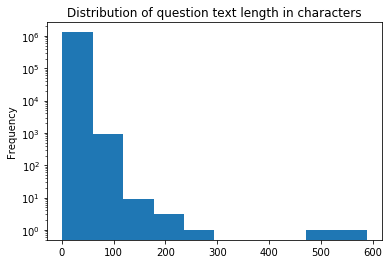

In [50]:
train['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters');

In [51]:
max_len = 72
maxlen = 72
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

In [52]:
y_train = train['target'].values

In [53]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [54]:
from sklearn.model_selection import StratifiedKFold
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=10).split(X_train, y_train))

In [56]:
embed_size = 300
embedding_path = "quora-insincere-questions-classification/embDict/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec"
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore') if len(o)>100)
all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/home/peihong/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### Net structure (most important part)

This single LSTM model structure contains several steps:
1. embedding
2. lstm
3. pooling(max and mean)
4. linear
5. dropout
6. linear

In class NeuralNet, function **\_\_init\_\_()**  initializes all the layers we need. Function  **forward()**  shows the structure of our model.

To test what are the output shape of every layer, simply add print() method in the **forward()** function and run the following code.

In [57]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        hidden_size = 128
        self.embedding = nn.Embedding(max_features, embed_size)# 120000, 300
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))#[120001, 300]
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(512, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(16, 1)
        
    def forward(self, x):
        h_embedding = self.embedding(x) #[512, 72, 300]
        h_embedding = torch.squeeze(self.embedding_dropout(torch.unsqueeze(h_embedding, 0)))#[512, 72, 300]
        h_lstm, _ = self.lstm(h_embedding)#[512, 72, 256]
        avg_pool = torch.mean(h_lstm, 1)#[512, 256]
        max_pool, _ = torch.max(h_lstm, 1)#[512, 256]
        conc = torch.cat((avg_pool, max_pool), 1)#[512, 512]
        conc = self.relu(self.linear(conc))#[512, 16]
        conc = self.dropout(conc)#[512, 16]
        out = self.out(conc)#[512, 1]
        return out

### Train model 

Steps for training a model is always the same, first we have to initialize our model as well as a optimizer and a loss function, then we put the data into the model (epoch and batch), then backward and optimizer.step(), finaly get the loss.

In [58]:
def train_model(model, x_train, y_train, x_val, y_val, validate=True):
    optimizer = torch.optim.Adam(model.parameters())
    
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean')#.cuda()
    
    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()
        avg_loss = 0.
        
        for x_batch, y_batch in tqdm(train_loader, disable=True):
            y_pred = model(x_batch)
            
            
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
            
        model.eval() # this is to let the model change to the evaluation version, which means after run this code, 
                     # the parameters will be locked, and all the following code can not change them.
            
            
            
            
            
#----------------------------------Skip these codes below in this cell---------------------------------
# These codes are just author's one way to use f1-score to calculate the accuracy. Since it's not as much
# important as how to use torch to write a net, it's highly recommended to skip this part.
        valid_preds = np.zeros((x_val_fold.size(0)))
        
        if validate:
            avg_val_loss = 0.
            for i, (x_batch, y_batch) in enumerate(valid_loader):
                y_pred = model(x_batch).detach()

                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                valid_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
            search_result = threshold_search(y_val.cpu().numpy(), valid_preds)

            val_f1, val_threshold = search_result['f1'], search_result['threshold']
            elapsed_time = time.time() - start_time
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t val_f1={:.4f} best_t={:.2f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_f1, val_threshold, elapsed_time))
        else:
            elapsed_time = time.time() - start_time
            print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, elapsed_time))
    
    valid_preds = np.zeros((x_val_fold.size(0)))
    
    avg_val_loss = 0.
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()

        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        valid_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]

    print('Validation loss: ', avg_val_loss)

    test_preds = np.zeros((len(test_loader.dataset)))
    
    for i, (x_batch,) in enumerate(test_loader):
        y_pred = model(x_batch).detach()

        test_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
    
    return valid_preds, test_preds

In [59]:
x_test_cuda = torch.tensor(X_test, dtype=torch.long)#.cuda()
test = torch.utils.data.TensorDataset(x_test_cuda)
batch_size = 512
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [60]:
# skip this cell, this is f1-score function part.
seed=1029

def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)], disable=True):
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
seed_everything()

In [61]:
# Train the model now!
train_preds = np.zeros(len(train))
test_preds = np.zeros((len(test), len(splits)))
n_epochs = 5
from tqdm import tqdm
from sklearn.metrics import f1_score
for i, (train_idx, valid_idx) in enumerate(splits):    
    x_train_fold = torch.tensor(X_train[train_idx], dtype=torch.long)#.cuda()
    y_train_fold = torch.tensor(y_train[train_idx, np.newaxis], dtype=torch.float32)#.cuda()
    x_val_fold = torch.tensor(X_train[valid_idx], dtype=torch.long)#.cuda()
    y_val_fold = torch.tensor(y_train[valid_idx, np.newaxis], dtype=torch.float32)#.cuda()
    
    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    print(f'Fold {i + 1}')
    
    seed_everything(seed + i)
    model = NeuralNet()
    #model.cuda()

    valid_preds_fold, test_preds_fold = train_model(model,x_train_fold,y_train_fold,x_val_fold,y_val_fold, validate=True)

    train_preds[valid_idx] = valid_preds_fold
    test_preds[:, i] = test_preds_fold
    


Fold 1
Epoch 1/5 	 loss=0.1461 	 val_loss=0.1121 	 val_f1=0.6358 best_t=0.28 	 time=2106.24s


KeyboardInterrupt: 

In [ ]:
search_result = threshold_search(y_train, train_preds)
sub['prediction'] = test_preds.mean(1) > search_result['threshold']
sub.to_csv("submission.csv", index=False)